# Experiments with textual misinformation detection using machine learning models
In this experiment, we train and test machine learning models for detecting misinformation based purely on the text. We evaluated the performance of 5 classification models with wide use in text classification problems.

**Models:**
* Logistic regression
* Bernoulli Naive-Bayes
* Complementary Naive-Bayes
* Linear SVM with SGD training
* Linear SVM
* SVM
* KNN
* Random forest
* Gradient Boosting
* Multilayer Perceptron

# NOTES TO MYSELF

**To do:**
* ~~n-grams~~
* ~~tunning svm~~
* ~~combine bow and handcrafted features~~
* ~~handcrafted linguistic features~~
* ~~hyperparamater tunning; validation~~


**References:**
* https://towardsdatascience.com/text-classification-in-python-dd95d264c802
* https://github.com/miguelfzafra/Latest-News-Classifier/tree/master/0.%20Latest%20News%20Classifier/04.%20Model%20Training


In [1]:
#utils
import emoji, re, string, time, os
from utils import getTestMetrics
import pandas as pd
import numpy as np
from scipy.stats import randint
import pickle

#nlp
import nltk
from nltk.corpus import stopwords
import spacy

#dataviz
import matplotlib.pyplot as plt
import seaborn as sns

#features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

#models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble  import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

#data balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

%matplotlib inline
sns.set(style="darkgrid")



## Experiments

## Subsets:
* Viral

# Feature engineering

### Vectorization
* bow: binary bag of words
* tfidf: term frequency–inverse document frequency

### N-grams
* unigram
* unigram-bigram
* unigram-bigram-trigram

### Limit features
* no limit
* max_features: limits to 500

### Pre-processing
* processed: convert url in just the domain, separate emojis, remove punctuation, downcase, lemmatization, remove stop words

### Conclusions:
* Smote is not the best oversampling technique for text, specially for BOW features
* Pre-processing the data didn't appear to have a great impact, despite the great reduction of dimentionality
* BOW features are comparably to TF-IDF features
* Random oversampling is a good oversampling technique
* Use a maximum number of features wasn't a good approach
* Better results are achivied when using unigrams, bigrams and trigrams



In [74]:
base = '2018'
subset = 'k-fold-sentences'
results_dir = 'results/' + str(base) + '/' + subset + '/ml/'
results_dir

'results/2018/k-fold-sentences/ml/'

In [75]:
#data_dir = 'data/' + str(base) #+ '/vis_processed_texts.p'
#filepath = 'data/' + str(base) + '/fakeWhatsApp.BR_' + str(base) + '.csv'
df = pd.read_csv('data/2018/fakeWhatsApp.BR_2018_processed.csv')
df = df[df['viral']==1]
df = df[df['midia']==0]
#df = df[df['words']>50]
print(len(df))
df.head(5)   

5284


,id,date,hour,ddi,country,country_iso3,ddd,state,group,midia,...,sharings,text,misinformation,types,types/token ratio,char/word ratio,average chars by word,tokens,pre_processed_text,semi_processed_text
0,3631133147603888180,01/08/18,13:24,55,BRASIL,BRA,17,São Paulo,2018_1,0,...,2,O Bolsonaro tem que estar preparado pra respon...,0,9,1.000000,6.444444,5.555556,9,o bolsonaro estar preparar responder assim,o bolsonaro tem que estar preparado pra respon...
1,3631133147603888180,10/08/18,14:31,55,BRASIL,BRA,17,São Paulo,2018_1,0,...,2,"No dia 07 de Outubro, quando for votar, não es...",1,18,1.000000,5.500000,4.555556,18,o dia 07 outubro votar esquecer esquerdopatas ...,"no dia 07 de outubro , quando for votar , não ..."
2,-4391661641377612003,11/08/18,19:28,55,BRASIL,BRA,13,São Paulo,2018_1,0,...,6,Devido a aborrecimentos nas varias redes socia...,0,17,1.000000,6.705882,5.764706,17,dever aborrecimento variar rede social postar ...,devido a aborrecimentos nas varias redes socia...
3,3631133147603888180,15/08/18,19:23,55,BRASIL,BRA,17,São Paulo,2018_1,0,...,7,EU GOSTARIA DE PEDIR A TODOS DO GRUPOS ENTREM ...,0,40,0.851064,7.021277,5.978723,47,eu gostar pedir todo grupo entrar neste linkkk...,eu gostaria de pedir a todos do grupos entrem ...
4,-4391661641377612003,22/08/18,22:11,55,BRASIL,BRA,13,São Paulo,2018_1,0,...,8,Como são as coisas.\nChefe do jacaré aparece n...,1,34,0.871795,5.794872,4.820513,39,comer coisa \n chefe jacaré aparecer video bal...,como são as coisas . \n chefe do jacaré aparec...


In [76]:
# misinformation = list(df[df['misinformation']==1]['text'])
# misinformation = [preprocess(m,semi=True, rpunct = False, remoji = True) for m in misinformation]
# misinformation = ' '.join(misinformation)
# misinformation

In [77]:
# text_file = open('misinformation.txt','wt')
# text_file.write(misinformation)
# text_file.close()

# Let's take a look in the data

In [78]:
for m in df[df['misinformation']==1]['text'].unique()[0:5]:
    print()
    print(m)
    print()
    print('..................................')


No dia 07 de Outubro, quando for votar, não esqueça do que os esquerdopatas pensam da classe média.

..................................

Como são as coisas.
Chefe do jacaré aparece no video baleado e pessoal no video falando que é morador, falam muita merda tentando colocar as forças armadas como vilão.
Quando chegou no hospital foi reconhecido e preso pela PM.

..................................

*No Ceará, o Comando Vermelho( CV ) PROIBIU propaganda de BOLSONARO  nos territórios que* *"administra"*
*Somente LULA E CIRO Podem.  Por serem aliados do CRIME.*
Alguém tem dúvida agora da quadrilha?  

https://www.opovo.com.br/jornal/reportagem/2018/08/a-interferencia-das-faccoes-criminosas-no-processo-eleitoral.html

*Agora é oficial*

..................................

Como falar que o cara não pode ser presidente se em 27 minutos ele:
- lembrou que o bonner levou chifre
- que bonner ganha 4x mais que a Renata
- Mostrou que o kit gay pode ser usado na escola mas não mostrado na TV 22h d

In [79]:
for m in df[df['misinformation']==0]['text'].unique()[0:5]:
    print()
    print(m)
    print()
    print('..................................')


O Bolsonaro tem que estar preparado pra responder assim...

..................................

Devido a aborrecimentos nas varias redes sociais não vou postar mais nada de política,agora so mulheres bonitas...

..................................

EU GOSTARIA DE PEDIR A TODOS DO GRUPOS ENTREM NESTE LINK VOTE E ESCOLHA SEU CANDIDATO A PRESIDENTE E COMPARTILHEM AO MAXIMO NAS REDES SOCIAIS DE NORTE A SUL DE LESTE A OESTE , INDIFERENTE DE SUA IDEOLOGIA 

*Detalhe:Vc não consegue votar 2 vezes ou mais.*

https://www.opinionstage.com/palmelonews1/em-quem-vc-vota-para-presidente

..................................

A ratoeira funcionou mais a ratazana aguentou a dor calada kkkkkkkk

..................................

Duas das maiores potências em vendas no Mundo, Coca Cola e Havaianas, se uniram para a maior campanha educacional visando a redução da criminalidade no país.

..................................


# Corpus statistics

In [80]:
df.describe()[['characters','words','sharings']]

,characters,words,sharings
count,5284.000000,5284.000000,5284.000000
mean,484.764194,74.220855,3.950038
std,938.905845,148.203533,5.363783
min,23.000000,6.000000,2.000000
25%,95.750000,13.000000,2.000000
50%,177.000000,25.000000,2.000000
75%,410.250000,63.000000,4.000000
max,15683.000000,2664.000000,91.000000


data after remove duplicates


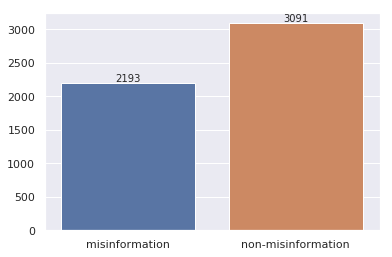

In [81]:
#removing duplicates    
df = df.drop_duplicates(subset=['text'])    
texts = df[df['midia']==0]['text']
y = df[df['midia']==0]['misinformation']

print('data after remove duplicates')
pos_mask = y == 1 
pos = y[pos_mask]
neg_mask = y == 0 
neg = y[neg_mask]
values = [pos.shape[0],neg.shape[0]]
keys = ['misinformation', 'non-misinformation']
g = sns.barplot(x = keys, y = values)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                               p.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 5), textcoords = 'offset points')

In [82]:
print(len(texts))
print(len(y))

5284
5284


In [83]:
# def avgSizeWords(string):
#     list_string = string.split()
#     chars = np.array([len(s) for s in list_string])
#     return chars.mean()    
# df['types'] = [len(set(t.split())) for t in df['text']]
# df['types/token ratio'] = df['types']/df['words']
# df['char/word ratio'] = df['characters']/df['words']
# df['average chars by word'] = [avgSizeWords(t) for t in df['text']]

In [84]:
mis = df[df['misinformation']==1][['words','types','types/token ratio' ,'characters', 'char/word ratio', 'average chars by word','sharings']].mean().to_frame().rename(columns={0: "misinformation"})
non_mis = df[df['misinformation']==0][['words','types','types/token ratio' ,'characters', 'char/word ratio', 'average chars by word','sharings']].mean().to_frame().rename(columns={0: "non-misinformation"})
mis.join(non_mis, lsuffix='_misinformation', rsuffix='_non-misinformation')

,misinformation,non-misinformation
words,106.556772,51.279198
types,73.787506,38.030087
types/token ratio,0.855165,0.912381
characters,674.312358,350.283727
char/word ratio,6.727408,7.277105
average chars by word,5.669311,6.242654
sharings,4.830825,3.325137


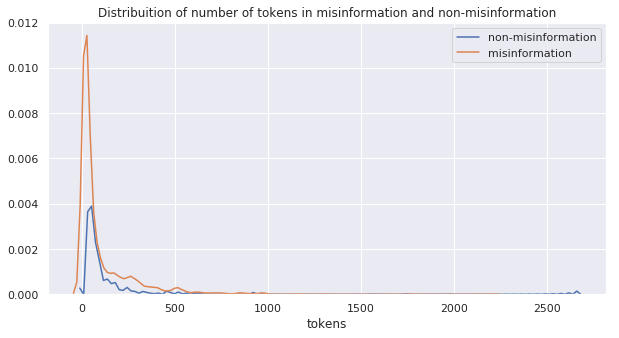

In [85]:
df['tokens'] = df['words']
plt.figure(figsize=(10, 5))
plt.title('Distribuition of number of tokens in misinformation and non-misinformation')
sns.distplot(df[df['misinformation']==0]['tokens'], hist = False, kde = True, label = 'non-misinformation')
sns.distplot(df[df['misinformation']==1]['tokens'], hist = False, kde = True, label = 'misinformation')
plt.show()

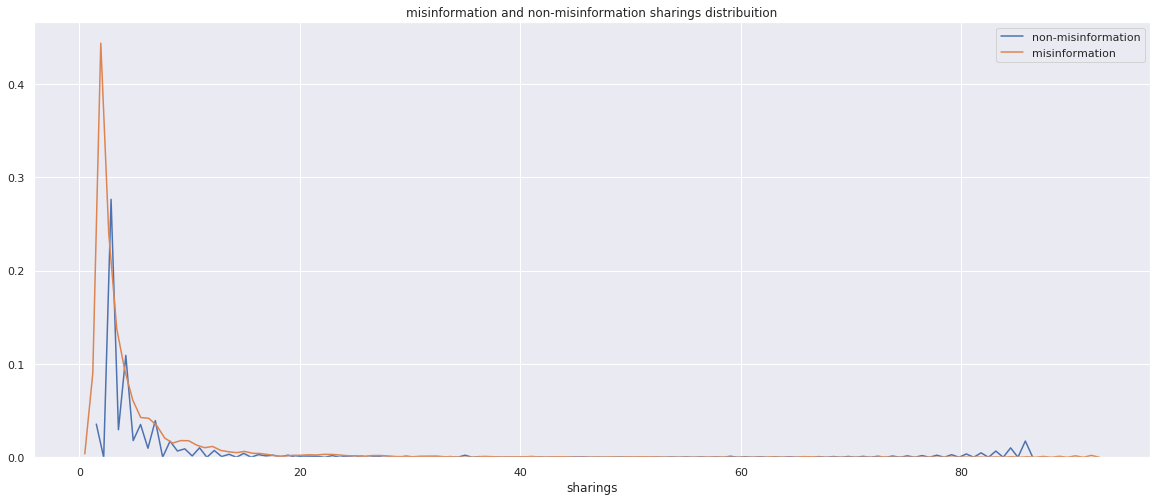

In [86]:
plt.figure(figsize=(20, 8))
plt.title('misinformation and non-misinformation sharings distribuition')
sns.distplot(df[df['misinformation']==0]['sharings'], hist = False, kde = True, label = 'non-misinformation')
sns.distplot(df[df['misinformation']==1]['sharings'], hist = False, kde = True, label = 'misinformation')
plt.show()

# Pre-processing
* convert url in just the domain
* separate emojis
* punctuation

[Some suggestions in this work](https://github.com/miguelfzafra/Latest-News-Classifier/blob/master/0.%20Latest%20News%20Classifier/03.%20Feature%20Engineering/03.%20Feature%20Engineering.ipynb)

* **Special character cleaning**

* **Upcase/downcase**

* **Punctuation signs** 

* **Possessive pronouns**

* **Stemming or Lemmatization**

* **Stop words**

In [100]:
#emojis and punctuation
emojis_list = list(emoji.UNICODE_EMOJI.keys())
emojis_list += ['\n']
punct = list(string.punctuation) + ['\n']
emojis_punct = emojis_list + punct

def processEmojisPunctuation(text, remove_punct = False, remove_emoji = False):
    '''
    Put spaces between emojis. Removes punctuation.
    '''
    #get all unique chars
    chars = set(text)
    #for each unique char in text, do:
    for c in chars:
        
        if remove_punct: #remove punctuation            
            if c in punct: 
                text = text.replace(c, ' ')
        else: #put spaces between punctuation
            if c in punct:
                text = text.replace(c, ' ' + c + ' ')
        
        if remove_emoji: #remove emojis
            if c in emojis_list:
                text = text.replace(c, ' ')
        else: #put spaces between emojis
            if c in emojis_list:
                text = text.replace(c, ' ' + c + ' ')                        
            
    text = re.sub(' +', ' ', text)
    return text

#stop words removal
stop_words = list(stopwords.words('portuguese'))
new_stopwords = ['aí','pra','vão','vou','onde','lá','aqui',
                 'tá','pode','pois','so','deu','agora','todo',
                 'nao','ja','vc', 'bom', 'ai','ta', 'voce', 'alguem', 'ne', 'pq',
                 'cara','to','mim','la','vcs','tbm', 'tudo']
stop_words = stop_words + new_stopwords
final_stop_words = []
for sw in stop_words:
    sw = ' '+ sw + ' '
    final_stop_words.append(sw)

def removeStopwords(text):
    for sw in final_stop_words:
        text = text.replace(sw,' ')
    text = re.sub(' +',' ',text)
    return text

#lemmatization
nlp = spacy.load('pt_core_news_sm')
def lemmatization(text):
    doc = nlp(text)
    for token in doc:
        if token.text != token.lemma_:
            text = text.replace(token.text, token.lemma_)
    return text
    

def domainUrl(text):
    '''
    Substitutes an URL in a text for the domain of this URL
    Input: an string
    Output: the string with the modified URL
    '''    
    if 'http' in text:
        re_url = '[^\s]*https*://[^\s]*'
        matches = re.findall(re_url, text, flags=re.IGNORECASE)
        for m in matches:
            domain = m.split('//')
            domain = domain[1].split('/')[0]
            text = re.sub(re_url, domain, text, 1)
        return text
    else:
        return text
    
def processLoL(text):
    re_kkk = 'kkk*'
    t = re.sub(re_kkk, "kkk", text, flags=re.IGNORECASE)
    return t

def firstSentence(text):
    list_s = re.split('; |\. |\! |\? |\n',text)
    for s in list_s:
        if s is not None:
            return s
    

def preprocess(text,semi=False, rpunct = False, remoji = False, sentence = False):
    if sentence:
        text = firstSentence(text) # remove
    text = text.lower().strip()
    text = domainUrl(text)
    text = processLoL(text)
    text = processEmojisPunctuation(text,remove_punct = rpunct, remove_emoji=remoji)
    if semi:        
        return text
    text = removeStopwords(text)
    text = lemmatization(text)
    return text
           

In [101]:
# just first sentence
if 'sentence' in subset:
    df['pre_processed_text'] = [preprocess(t, sentence = True) for t in texts]
    df['semi_processed_text'] = [preprocess(t,semi=True, sentence = True) for t in texts]


In [213]:
# df['pre_processed_text'] = [preprocess(t) for t in texts]
# df['semi_processed_text'] = [preprocess(t,semi=True) for t in texts]
# df.to_csv('data/2018/fakeWhatsApp.BR_2018_processed.csv',index = False)

In [102]:
pro_texts = df['pre_processed_text']
semi_pro_texts = df['semi_processed_text']

def trucateText(text):
    words = text.split()
    if len(words) <= 100:
        return text
    else:
        words = words[0:100]
        text = ' '.join(words)
        return text

if 'trunc' in subset:
    pro_texts = [trucateText(t) for t in pro_texts]
    semi_pro_texts = [trucateText(t) for t in semi_pro_texts]
    

In [103]:
list(zip(pro_texts[100:120], semi_pro_texts[100:120]))

[('caro irmão digno irmão , paz deus ! ! ! ',
  'caros irmãos e digníssimas irmãs , a paz de deus ! ! ! '),
 ('• acre ( ac ) ', '• acre ( ac ) '),
 ('alguém conhecer alguém pernambuco algum grupar bolsonaro lá',
  'alguém aí conhece alguém de pernambuco ou algum grupo bolsonaro de lá'),
 ('pesquisar ibope contratar tv globo',
  'pesquisa ibope contratada pela tv globo'),
 ('ser mídia maldizer ibope datalixo continuar mentir demonizando bolsonaro',
  'será que essa mídia maldita e esses ibope e datalixo vão continuar mentindo e demonizando o bolsonaro'),
 ('bolsonaro levar facada pouco', 'bolsonaro levou uma facada agora pouco'),
 ('todo palmense bolsonaro , encontrar hoje praça girassol 18 : 30 apoiar recuperação presidente , levar bandeiro , apito , vulvuzela . ',
  'todos os palmense que estão com bolsonaro , encontro hoje na praça dos girassóis as 18 : 30 em apoio à recuperação do nosso presidente , levem bandeiras , apitos , vulvuzela . '),
 ('todo palmense bolsonaro , encontrar ho

In [104]:
print(len(pro_texts))
print(len(y))

5284
5284


# Experiments and models

In [105]:
vectorization = ['bow','tfidf']
ngrams = ['-unigram', '-unigram_bigram','-unigram_bigram_trigram']
processed = ['','-pre_processed']
max_features = ['']#,'-max_features']
balancing = ['','-oversampling']
experiments = []

for vec in vectorization:
    for ng in ngrams:
        for p in processed:
            for m in max_features:
                exp = vec+ng+p+m
                experiments.append(exp)

print(len(experiments))
experiments


12


['bow-unigram',
 'bow-unigram-pre_processed',
 'bow-unigram_bigram',
 'bow-unigram_bigram-pre_processed',
 'bow-unigram_bigram_trigram',
 'bow-unigram_bigram_trigram-pre_processed',
 'tfidf-unigram',
 'tfidf-unigram-pre_processed',
 'tfidf-unigram_bigram',
 'tfidf-unigram_bigram-pre_processed',
 'tfidf-unigram_bigram_trigram',
 'tfidf-unigram_bigram_trigram-pre_processed']

In [106]:
models = ['lr','nb','lsvm','sgd', 'svm', 'knn', 'rf', 'gb', 'mlp']
print(len(models))
models

9


['lr', 'nb', 'lsvm', 'sgd', 'svm', 'knn', 'rf', 'gb', 'mlp']

## Train-test split

In [107]:
experiment = experiments[-2]
model = models[-1]

In [65]:
#random state = 42 for reprudictibility
if 'pre_processed' in experiment:
    X_texts = pro_texts
else:
    X_texts = semi_pro_texts
    
texts_train, texts_test, y_train, y_test = train_test_split(X_texts, y, test_size=0.2, 
                                                                    stratify = y, random_state=42)

full_texts_train, full_texts_test, y_train, y_test = train_test_split(texts, y, test_size=0.2, 
                                                                    stratify = y, random_state=42)

In [108]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold


## Vectorization

In [109]:
print(experiment,model)

tfidf-unigram_bigram_trigram mlp


In [110]:
def defineVectorizing(experiment):
    max_feat = None
    # maximum number of features
    if 'max_features' in experiment:
        max_feat = 5000
    exp_parts = experiment.split('-')
    vec = exp_parts[0]
    ngram = exp_parts[1]
    # ngram
    if ngram == 'unigram':
        ng = (1,1)
    elif ngram == 'unigram_bigram':
        ng = (1,2)
    elif ngram == 'unigram_bigram_trigram':
        ng = (1,3)
    # vectorizer
    if vec == 'bow':
        vectorizer = CountVectorizer(max_features = max_feat, binary=True, ngram_range = ng, lowercase = False, token_pattern = r'[^\s]+')
    elif vec == 'tfidf':
        vectorizer = TfidfVectorizer(max_features = max_feat, ngram_range = ng, lowercase = False, token_pattern = r'[^\s]+')
    
    return vectorizer

def vectorizing(vectorizer,texts_train,texts_test):
    vectorizer.fit(texts_train)   
    X_train = vectorizer.transform(texts_train)
    X_test = vectorizer.transform(texts_test)
    #print('Train:',X_train.shape)
    #print('Test:',X_test.shape)
    return X_train, X_test

vectorizer = defineVectorizing(experiment)
X_train,X_test = vectorizing(vectorizer,texts_train,texts_test)

## Models training and test

In [117]:
def lr_eval(X_train,y_train,X_test,y_test):
    #print('Logistic Regression')
    logreg = LogisticRegression().fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    y_prob = logreg.predict_proba(X_test)[:,1]
    return getTestMetrics(y_test, y_pred, y_prob, full_metrics = True, print_charts=False)

def nb_eval(X_train,y_train,X_test,y_test):    
    if 'bow' in experiment:
        #print('Bernoulli Naive-Bayes')
        nb = BernoulliNB().fit(X_train, y_train)
    elif 'tfidf' in experiment:
        #print('Complement Naive-Bayes')
        nb = ComplementNB().fit(X_train, y_train)
    # print('Bernoulli Naive-Bayes')
    y_pred = nb.predict(X_test)
    y_prob = nb.predict_proba(X_test)[:,1]
    return getTestMetrics(y_test, y_pred, y_prob, full_metrics = True, print_charts=False)

def lsvm_eval(X_train,y_train,X_test,y_test):
    #print('Linear Support Vector Machine')
    svm = LinearSVC(dual=False).fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    return getTestMetrics(y_test, y_pred, full_metrics = True,print_charts=False)

def sgd_eval(X_train,y_train,X_test,y_test):
    #print('Linear SVM with SGD training')
    sgd = SGDClassifier().fit(X_train, y_train)
    y_pred = sgd.predict(X_test)
    return getTestMetrics(y_test, y_pred, full_metrics = True,print_charts=False)

def svm_eval(X_train,y_train,X_test,y_test):
    #print('SVM with RBF kernel')
    #svm = SVC(probability=True).fit(X_train, y_train)
    svc = SVC(probability=True).fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    y_prob = svc.predict_proba(X_test)[:,1]
    return getTestMetrics(y_test, y_pred,y_prob, full_metrics = True,print_charts=False)

def knn_eval(X_train,y_train,X_test,y_test):
    #print('KNN')
    knn = KNeighborsClassifier(weights='distance',n_jobs=-1).fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    y_prob = knn.predict_proba(X_test)[:,1]
    return getTestMetrics(y_test, y_pred, y_prob, full_metrics = True, print_charts=False)

def rf_eval(X_train,y_train,X_test,y_test):
    #print('Random Forest')
    #rf = RandomForestClassifier(n_estimators=200,n_jobs=-1).fit(X_train, y_train)
    rf = RandomForestClassifier(n_jobs=-1).fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:,1]
    return getTestMetrics(y_test, y_pred, y_prob, full_metrics = True, print_charts=False)

def gb_eval(X_train,y_train,X_test,y_test):
    #print('Gradient Boosting')
    gb = GradientBoostingClassifier(n_estimators=200).fit(X_train, y_train)
    y_pred = gb.predict(X_test)
    y_prob = gb.predict_proba(X_test)[:,1]
    return getTestMetrics(y_test, y_pred, y_prob, full_metrics = True, print_charts=False)

def mlp_eval(X_train,y_train,X_test,y_test):
    #print('Multilayer perceptron')
    mlp = MLPClassifier(verbose=True, early_stopping= True, batch_size=64, n_iter_no_change = 5, tol = 1e-3).fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    y_prob = mlp.predict_proba(X_test)[:,1]
    return getTestMetrics(y_test, y_pred, y_prob, full_metrics = True, print_charts=False)

def model_eval(model,X_train,y_train,X_test,y_test):
    if model == 'lr':
        return lr_eval(X_train,y_train,X_test,y_test)
    elif model == 'nb':
        return nb_eval(X_train,y_train,X_test,y_test)
    elif model == 'lsvm':
        return lsvm_eval(X_train,y_train,X_test,y_test)
    elif model == 'sgd':
        return sgd_eval(X_train,y_train,X_test,y_test)
    elif model == 'svm':
        return svm_eval(X_train,y_train,X_test,y_test)
    elif model == 'knn':
        return knn_eval(X_train,y_train,X_test,y_test)
    elif model == 'rf':
        return rf_eval(X_train,y_train,X_test,y_test)
    elif model == 'gb':
        return gb_eval(X_train,y_train,X_test,y_test)
    elif model == 'mlp':
        return mlp_eval(X_train,y_train,X_test,y_test)

#lsvm_eval(X_train,y_train,X_test,y_test)
model_eval('nb',X_train,y_train,X_test,y_test)

AUC:  0.8026479716330878


(0.7256385998107853,
 0.7250755287009063,
 0.7842261904761905,
 0.5466970387243736,
 0.7842261904761905,
 0.6233766233766234,
 0.7842261904761905,
 0.8026479716330878)

In [113]:
def buildResults(models,vocab, accuracy_score, precision_score, precision_score_neg,recall_score, recall_score_neg, f1_score, f1_score_neg, auc_score):
    df_metrics = pd.DataFrame({'model':models,                                 
                                 'vocab':[vocab]*len(models),
                                 'auc': auc_score,
                                 'accuracy':accuracy_score,
                                 'precision 1': precision_score,
                                 'recall 1': recall_score,
                                 'f1 score 1': f1_score,
                                 'precision 0': precision_score_neg,
                                 'recall 0': recall_score_neg,                                 
                                 'f1 score 0': f1_score_neg
                                 })    
    df_metrics['precision avg'] = (df_metrics['precision 1'] + df_metrics['precision 0'])/2
    df_metrics['recall avg'] = (df_metrics['recall 1'] + df_metrics['recall 0'])/2
    df_metrics['f1 avg'] = (df_metrics['f1 score 1'] + df_metrics['f1 score 0'])/2
    df_metrics['fpr'] = 1 - df_metrics['recall 0']
    return df_metrics


In [114]:
# scores = cross_val_score(mlp, X_train, y_train, cv=10, scoring='f1')
# print("F1: %0.3f +/- %0.3f" % (scores.mean(), scores.std() * 2))

In [115]:
results_dir

'results/2018/k-fold-sentences/ml/'

# Run experiments

In [230]:
def runExperimentsTrainTest(experiments, models):
    total_start_time = time.time()
    
    for experiment in experiments:
        
        #if the experiment was already made, continue
        #results_dir = 'results/2018/viral_2/ml/'
        experiment_file = experiment + '.csv'
        filepath = results_dir + experiment_file
        print(filepath)
        list_files = os.listdir(results_dir)
        if experiment_file in list_files:
            continue        
        
        #measure experiment time
        start_time = time.time()
        
        # train-test split
        if 'pre_processed' in experiment:
            X_texts = pro_texts
        else:
            X_texts = semi_pro_texts
        texts_train, texts_test, y_train, y_test = train_test_split(X_texts, y, 
                                                                    test_size=0.2, stratify = y, 
                                                                    random_state=42)        
        # features
        vectorizer = defineVectorizing(experiment)
        X_train,X_test = vectorizing(vectorizer,texts_train,texts_test)
        vocab = X_train.shape[1]
        
        # metrics
        accuracy_score = []
        precision_score = []
        precision_score_neg = []
        recall_score = []
        recall_score_neg = []
        f1_score = []
        f1_score_neg = []
        auc_score = []
        
        experiment_time = time.time()
        for model in models:
            acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = model_eval(model,
                                                                                                X_train,
                                                                                                y_train,
                                                                                                X_test,
                                                                                                y_test)
            accuracy_score.append(acc)
            precision_score.append(precision)
            precision_score_neg.append(precision_neg)
            recall_score.append(recall)
            recall_score_neg.append(recall_neg)
            f1_score.append(f1)
            f1_score_neg.append(f1_neg)
            auc_score.append(roc_auc)
            
        df_metrics = buildResults(models,vocab,accuracy_score,
                                  precision_score,precision_score_neg,
                                  recall_score,recall_score_neg,
                                  f1_score,f1_score_neg,auc_score)


            
        df_metrics.to_csv(filepath,index=False)
        end_time = time.time()
        ellapsed_time = end_time - start_time
        print(experiment + ' time (minutes):', ellapsed_time/60)
    
    total_end_time = time.time()
    total_ellapsed_time = total_end_time - total_start_time
    print()
    print('---------------------')
    print()
    print('TOTAL time (minutes):', total_ellapsed_time/60)   
        
        
        
    

In [231]:
runExperimentsTrainTest(experiments,models)

results/2018/k-fold-50/ml/tfidf-unigram_bigram_trigram-pre_processed.csv
AUC:  0.9042508417508417
AUC:  0.9002946127946128
AUC:  0.9157407407407407
AUC:  0.8644149831649831
AUC:  0.9200547138047137
AUC:  0.8797558922558922
Iteration 1, loss = 0.65601312
Validation score: 0.696000
Iteration 2, loss = 0.44255506
Validation score: 0.728000
Iteration 3, loss = 0.25957247
Validation score: 0.752000
Iteration 4, loss = 0.15136436
Validation score: 0.744000
Iteration 5, loss = 0.09772508
Validation score: 0.768000
Iteration 6, loss = 0.06926189
Validation score: 0.784000
Iteration 7, loss = 0.05447132
Validation score: 0.784000
Iteration 8, loss = 0.04543239
Validation score: 0.776000
Iteration 9, loss = 0.03826862
Validation score: 0.776000
Iteration 10, loss = 0.03371183
Validation score: 0.776000
Iteration 11, loss = 0.03021158
Validation score: 0.776000
Iteration 12, loss = 0.02610462
Validation score: 0.776000
Validation score did not improve more than tol=0.001000 for 5 consecutive epoc

# K-Folds

In [119]:
def kFoldsEvaluate(model,experiment,X_texts):
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    auc_list = []
    fpr_list = []
    vocabs = []
    
    skf = StratifiedKFold(n_splits=5)
    i=0
    for train_index, test_index in skf.split(X_texts, y):
        i+=1
        X_train, X_test = X_texts[train_index], X_texts[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if 'oversampling' in experiment:
            ros = RandomOverSampler(random_state=42)
            X_train, y_train = ros.fit_resample(X_train, y_train)

        # vectorization
        vectorizer = defineVectorizing(experiment)
        X_train,X_test = vectorizing(vectorizer, X_train, X_test)
        vocab = X_train.shape[1]
        #print(vocab)
        # model
        print(model + str(i))
        acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = model_eval(model,
                                                                                                    X_train,
                                                                                                    y_train,
                                                                                                    X_test,
                                                                                                    y_test)
        vocabs.append(vocab)
        accuracy_list.append(acc)
        precision_list.append(precision)
        recall_list.append(recall)    
        f1_list.append(f1)    
        auc_list.append(roc_auc)
        fpr_list.append(1-recall_neg)

    vocab_mean = np.floor(np.array(vocabs).mean())
    accuracy_mean = np.array(accuracy_list).mean()
    precision_mean = np.array(precision_list).mean()
    recall_mean = np.array(recall_list).mean()
    f1_mean = np.array(f1_list).mean()
    auc_mean = np.array(auc_list).mean()
    fpr_mean = np.array(fpr_list).mean()
    
    accuracy_std = np.array(accuracy_list).std()
    precision_std = np.array(precision_list).std()
    recall_std = np.array(recall_list).std()
    f1_std = np.array(f1_list).std()
    auc_std = np.array(auc_list).std()
    fpr_std = np.array(fpr_list).std()
    
    return vocab_mean, accuracy_mean, accuracy_std, precision_mean,precision_std, recall_mean, recall_std, f1_mean, f1_std, auc_mean, auc_std, fpr_mean, fpr_std
#kFoldsEvaluate(model,experiment,X_texts)

In [120]:
def buildResultsKFold(models,vocab,metrics_list):
    df_metrics = pd.DataFrame({'model':models,
                               'vocab':[vocab]*len(models),
                               'acc_mean': metrics_list[0],
                               'acc_std': metrics_list[1],
                               'pre_mean': metrics_list[2],
                               'pre_std': metrics_list[3],
                               'rec_mean': metrics_list[4],
                               'rec_std': metrics_list[5],
                               'f1_mean': metrics_list[6],
                               'f1_std': metrics_list[7],
                               'auc_mean': metrics_list[8],
                               'auc_std': metrics_list[9],
                               'fpr_mean': metrics_list[10],
                               'fpr_std': metrics_list[11]
                              })    
#     df_metrics['precision avg'] = (df_metrics['precision 1'] + df_metrics['precision 0'])/2
#     df_metrics['recall avg'] = (df_metrics['recall 1'] + df_metrics['recall 0'])/2
#     df_metrics['f1 avg'] = (df_metrics['f1 score 1'] + df_metrics['f1 score 0'])/2
#     df_metrics['fpr'] = 1 - df_metrics['recall 0']
    return df_metrics

In [121]:
def runExperimentsKFolds(experiments, models):
    total_start_time = time.time()
    
    for experiment in experiments:
        
        #if the experiment was already made, continue
        #results_dir = 'results/2018/k-fold/ml/'
        experiment_file = experiment + '.csv'
        filepath = results_dir + experiment_file
        print(filepath)
        list_files = os.listdir(results_dir)
        if experiment_file in list_files:
            continue        
        
        #measure experiment time
        start_time = time.time()
        
        # train-test split
        if 'pre_processed' in experiment:
            X_texts = pro_texts
        else:
            X_texts = semi_pro_texts
        
        # metrics
        acc_mean = []
        acc_std = []
        pre_mean = []
        pre_std = []
        rec_mean = []
        rec_std = []
        f1_score_mean = []
        f1_score_std = []
        auc_score_mean = []
        auc_score_std = []
        fpr_score_mean = []
        fpr_score_std = []       
        
        
        
        experiment_time = time.time()
        for model in models:
            vocab, accuracy_mean, accuracy_std, precision_mean,precision_std, recall_mean, recall_std, f1_mean, f1_std, auc_mean, auc_std, fpr_mean, fpr_std = kFoldsEvaluate(model,experiment,X_texts)
            
            acc_mean.append(accuracy_mean)
            acc_std.append(accuracy_std)
            pre_mean.append(precision_mean)
            pre_std.append(precision_std)
            rec_mean.append(recall_mean)
            rec_std.append(recall_std)
            f1_score_mean.append(f1_mean)
            f1_score_std.append(f1_std)
            auc_score_mean.append(auc_mean)
            auc_score_std .append(auc_std)
            fpr_score_mean.append(fpr_mean)
            fpr_score_std.append(fpr_std)
            
             

        metrics_list = [acc_mean,
                        acc_std,
                        pre_mean,
                        pre_std,
                        rec_mean,
                        rec_std,
                        f1_score_mean,
                        f1_score_std,
                        auc_score_mean,
                        auc_score_std,
                        fpr_score_mean,
                        fpr_score_std]
        
        end_time = time.time()
        ellapsed_time = end_time - start_time
        print(experiment + ' time (minutes):', ellapsed_time/60)
        
        # save results
        df_metrics = buildResultsKFold(models,vocab,metrics_list)            
        df_metrics.to_csv(filepath,index=False)
        

    
    total_end_time = time.time()
    total_ellapsed_time = total_end_time - total_start_time
    print()
    print('---------------------')
    print()
    print('TOTAL time (minutes):', total_ellapsed_time/60) 


In [124]:
experiments[-1]

'tfidf-unigram_bigram_trigram-pre_processed'

In [126]:
runExperimentsKFolds([experiments[-1]], models)

results/2018/k-fold-sentences/ml/tfidf-unigram_bigram_trigram-pre_processed.csv
lr1
AUC:  0.7704575799824434
lr2
AUC:  0.7684683489248144
lr3
AUC:  0.7544820900693693
lr4
AUC:  0.7070736669836566
lr5
AUC:  0.7388560092210844
nb1
AUC:  0.7537234160267334
nb2
AUC:  0.7831457195302652
nb3
AUC:  0.7689383049148182
nb4
AUC:  0.7441430582892864
nb5
AUC:  0.7533230630550752
lsvm1
lsvm2
lsvm3
lsvm4
lsvm5
sgd1
sgd2
sgd3
sgd4
sgd5
svm1
AUC:  0.7742602961028615
svm2
AUC:  0.780254107968242
svm3
AUC:  0.7587153799087364
svm4
AUC:  0.719040036564419
svm5
AUC:  0.7393769118233807
knn1
AUC:  0.7346305353309579
knn2
AUC:  0.7041064938702996
knn3
AUC:  0.7024551975289529
knn4
AUC:  0.6788634068307642
knn5
AUC:  0.6834870180727342
rf1
AUC:  0.7726355662764364
rf2
AUC:  0.7459989237086346
rf3
AUC:  0.736168550176556
rf4
AUC:  0.7036402238096292
rf5
AUC:  0.710481594774719
gb1
AUC:  0.7153882753889393
gb2
AUC:  0.7007688848589395
gb3
AUC:  0.6905146294535242
gb4
AUC:  0.6683327067253467
gb5
AUC:  0.692030

## Results

In [127]:
results_dir = 'results/' + str(base) + '/' + subset + '/ml/'
results_dir

'results/2018/k-fold-sentences/ml/'

In [131]:
experiment = experiments[-1]
filepath = results_dir + experiment + '.csv'
print(filepath)

results/2018/k-fold-sentences/ml/tfidf-unigram_bigram_trigram-pre_processed.csv


In [134]:
df_metrics = pd.read_csv(filepath)
df_metrics['vocab'] = df_metrics['vocab'].astype('int64') 
# df_metrics['fpr'] = 1 - df_metrics['recall 0']
# df_met = df_metrics.rename(columns={"precision 1": "pre", "recall 1": "rec", "f1 score 1":"f1-score"})
pd.set_option('precision', 3)
# df_met[['vocab','model','fpr','pre','rec', 'f1-score']].style.background_gradient(cmap='binary')
cm = sns.light_palette("gray", as_cmap=True)
#[['model','vocab','fpr_mean','pre_mean','rec_mean','f1_mean']]
df_metrics[['model', 'vocab', 'acc_mean', 'pre_mean', 'rec_mean', 'f1_mean', 'auc_mean', 'fpr_mean']].style.background_gradient(cmap=cm)

,model,vocab,acc_mean,pre_mean,rec_mean,f1_mean,auc_mean,fpr_mean
0,lr,55325,0.691,0.665,0.514,0.580,0.748,0.244
1,nb,55325,0.699,0.661,0.563,0.608,0.761,0.244
2,lsvm,55325,0.694,0.632,0.631,0.631,0.000,0.261
3,sgd,55325,0.693,0.625,0.654,0.639,0.000,0.267
4,svm,55325,0.694,0.690,0.477,0.564,0.754,0.236
5,knn,55325,0.627,0.542,0.678,0.602,0.701,0.352
6,rf,55325,0.671,0.622,0.533,0.574,0.734,0.268
7,gb,55325,0.640,0.622,0.337,0.437,0.693,0.265
8,mlp,55325,0.700,0.648,0.611,0.628,0.771,0.251


In [133]:
df_metrics.columns

Index(['model', 'vocab', 'acc_mean', 'acc_std', 'pre_mean', 'pre_std',
       'rec_mean', 'rec_std', 'f1_mean', 'f1_std', 'auc_mean', 'auc_std',
       'fpr_mean', 'fpr_std'],
      dtype='object')

In [37]:
from IPython.display import display

In [38]:
def meanStdToString(mean,std):
    plusminus = ' ± '
    mean = str(mean)[0:5]
    std = str(std)[0:4]
    return str(mean)+plusminus+str(std)    

def highlight_max(x):
    if (x == df_metrics['Model']).all() or (x == df_metrics['vocab']).all():
        return ['' for v in x]
    elif (x == df_metrics['FPR']).all():
        return ['font-weight: bold' if v == x.min() else '' for v in x]
        
    return ['font-weight: bold' if v == x.max() else '' for v in x]



# experiment = experiments[i]
# print(str(i) + ' ' + experiment)
# i+=1

for filename in os.listdir(results_dir):
    experiment = filename.replace('.csv','')
    file_path = results_dir + filename
    print(file_path)

    df_metrics = pd.read_csv(file_path)    
    df_metrics['Model'] = [x.upper() for x in df_metrics['model']]
    df_metrics['ACC'] = df_metrics.apply(lambda x: meanStdToString(x['acc_mean'], x['acc_std']),axis=1)
    df_metrics['PRE'] = df_metrics.apply(lambda x: meanStdToString(x['pre_mean'], x['pre_std']),axis=1)
    df_metrics['REC'] = df_metrics.apply(lambda x: meanStdToString(x['rec_mean'], x['rec_std']),axis=1)
    df_metrics['F1'] = df_metrics.apply(lambda x: meanStdToString(x['f1_mean'], x['f1_std']),axis=1)
    df_metrics['FPR'] = df_metrics.apply(lambda x: meanStdToString(x['fpr_mean'], x['fpr_std']),axis=1)

    styles = [dict(selector="caption", 
        props=[("text-align", "center"),
        ("font-size", "120%"),
        ("color", 'black'),
        ("font-weight", "bold")])] 

    style = df_metrics[['Model','FPR','PRE','REC','F1']].style.apply(highlight_max)
    title = experiment.upper() + '. Features: ' + str(df_metrics.iloc[0].values[1])
    sheet = experiment.upper() + ' ' + str(df_metrics.iloc[0].values[1])
    sheet = sheet.replace('PRE_PROCESSED','PRE')
    sheet = sheet.replace('GRAM','')
    print(title)
    style = style.set_caption(title).set_table_styles(styles)
    #print(style.to_latex(index=False))
    
    print()
    display(style)
    print()
    #style.to_excel("results/2018/k-fold/plots/" + title + ".xlsx") 

results/2018/k-fold/ml/tfidf-unigram-pre_processed.csv
TFIDF-UNIGRAM-PRE_PROCESSED. Features: 19455.0



,Model,FPR,PRE,REC,F1
0,LR,0.188 ± 0.00,0.766 ± 0.01,0.621 ± 0.03,0.685 ± 0.01
1,NB,0.228 ± 0.00,0.764 ± 0.02,0.327 ± 0.03,0.457 ± 0.02
2,LSVM,0.196 ± 0.00,0.729 ± 0.01,0.694 ± 0.02,0.711 ± 0.00
3,SGD,0.199 ± 0.00,0.723 ± 0.01,0.694 ± 0.01,0.708 ± 0.00
4,SVM,0.181 ± 0.00,0.785 ± 0.01,0.620 ± 0.02,0.692 ± 0.01
5,KNN,0.241 ± 0.01,0.660 ± 0.02,0.643 ± 0.03,0.651 ± 0.02
6,RF,0.183 ± 0.00,0.819 ± 0.02,0.541 ± 0.03,0.651 ± 0.02
7,GB,0.200 ± 0.00,0.769 ± 0.01,0.532 ± 0.03,0.628 ± 0.02
8,MLP,0.192 ± 0.00,0.740 ± 0.02,0.681 ± 0.02,0.709 ± 0.00



results/2018/k-fold/ml/bow-unigram-pre_processed.csv
BOW-UNIGRAM-PRE_PROCESSED. Features: 19455.0



,Model,FPR,PRE,REC,F1
0,LR,0.181 ± 0.00,0.764 ± 0.01,0.678 ± 0.02,0.718 ± 0.00
1,NB,0.228 ± 0.00,0.764 ± 0.02,0.327 ± 0.03,0.457 ± 0.02
2,LSVM,0.203 ± 0.00,0.716 ± 0.01,0.690 ± 0.02,0.703 ± 0.01
3,SGD,0.198 ± 0.01,0.731 ± 0.01,0.669 ± 0.01,0.699 ± 0.01
4,SVM,0.186 ± 0.01,0.784 ± 0.01,0.588 ± 0.06,0.670 ± 0.03
5,KNN,0.219 ± 0.00,0.829 ± 0.03,0.311 ± 0.03,0.451 ± 0.03
6,RF,0.182 ± 0.00,0.803 ± 0.01,0.576 ± 0.05,0.669 ± 0.03
7,GB,0.196 ± 0.00,0.783 ± 0.00,0.529 ± 0.05,0.630 ± 0.03
8,MLP,0.182 ± 0.00,0.760 ± 0.01,0.684 ± 0.02,0.720 ± 0.00



results/2018/k-fold/ml/tfidf-unigram_bigram_trigram-pre_processed.csv
TFIDF-UNIGRAM_BIGRAM_TRIGRAM-PRE_PROCESSED. Features: 261665.0



,Model,FPR,PRE,REC,F1
0,LR,0.202 ± 0.01,0.723 ± 0.02,0.675 ± 0.03,0.698 ± 0.02
1,NB,0.228 ± 0.01,0.672 ± 0.01,0.741 ± 0.02,0.704 ± 0.01
2,LSVM,0.211 ± 0.01,0.692 ± 0.02,0.778 ± 0.02,0.732 ± 0.01
3,SGD,0.219 ± 0.01,0.680 ± 0.02,0.787 ± 0.01,0.729 ± 0.01
4,SVM,0.193 ± 0.01,0.751 ± 0.02,0.639 ± 0.03,0.690 ± 0.02
5,KNN,0.253 ± 0.01,0.641 ± 0.01,0.656 ± 0.01,0.648 ± 0.01
6,RF,0.194 ± 0.01,0.832 ± 0.01,0.453 ± 0.05,0.585 ± 0.04
7,GB,0.201 ± 0.00,0.768 ± 0.01,0.531 ± 0.02,0.628 ± 0.01
8,MLP,0.203 ± 0.00,0.704 ± 0.01,0.760 ± 0.01,0.731 ± 0.00



results/2018/k-fold/ml/tfidf-unigram_bigram.csv
TFIDF-UNIGRAM_BIGRAM. Features: 156182.0



,Model,FPR,PRE,REC,F1
0,LR,0.206 ± 0.01,0.725 ± 0.02,0.633 ± 0.03,0.675 ± 0.01
1,NB,0.222 ± 0.00,0.834 ± 0.02,0.281 ± 0.02,0.420 ± 0.03
2,LSVM,0.197 ± 0.01,0.721 ± 0.02,0.729 ± 0.03,0.724 ± 0.02
3,SGD,0.203 ± 0.01,0.709 ± 0.02,0.731 ± 0.03,0.720 ± 0.01
4,SVM,0.195 ± 0.01,0.752 ± 0.02,0.623 ± 0.05,0.680 ± 0.02
5,KNN,0.313 ± 0.02,0.577 ± 0.02,0.715 ± 0.03,0.639 ± 0.02
6,RF,0.192 ± 0.00,0.835 ± 0.02,0.462 ± 0.04,0.593 ± 0.03
7,GB,0.201 ± 0.00,0.752 ± 0.02,0.578 ± 0.03,0.652 ± 0.01
8,MLP,0.197 ± 0.01,0.722 ± 0.03,0.730 ± 0.03,0.725 ± 0.01



results/2018/k-fold/ml/bow-unigram_bigram_trigram.csv
BOW-UNIGRAM_BIGRAM_TRIGRAM. Features: 384783.0



,Model,FPR,PRE,REC,F1
0,LR,0.179 ± 0.01,0.782 ± 0.02,0.641 ± 0.03,0.704 ± 0.01
1,NB,0.256 ± 0.01,0.637 ± 0.01,0.804 ± 0.02,0.710 ± 0.01
2,LSVM,0.185 ± 0.01,0.772 ± 0.03,0.633 ± 0.03,0.695 ± 0.01
3,SGD,0.197 ± 0.01,0.725 ± 0.02,0.710 ± 0.04,0.716 ± 0.02
4,SVM,0.193 ± 0.01,0.844 ± 0.01,0.445 ± 0.06,0.579 ± 0.05
5,KNN,0.220 ± 0.00,0.890 ± 0.04,0.255 ± 0.04,0.394 ± 0.05
6,RF,0.194 ± 0.00,0.850 ± 0.02,0.432 ± 0.05,0.570 ± 0.04
7,GB,0.202 ± 0.00,0.757 ± 0.01,0.551 ± 0.04,0.637 ± 0.02
8,MLP,0.188 ± 0.01,0.762 ± 0.03,0.645 ± 0.05,0.696 ± 0.02



results/2018/k-fold/ml/tfidf-unigram_bigram_trigram.csv
TFIDF-UNIGRAM_BIGRAM_TRIGRAM. Features: 384783.0



,Model,FPR,PRE,REC,F1
0,LR,0.216 ± 0.01,0.699 ± 0.03,0.676 ± 0.03,0.686 ± 0.02
1,NB,0.245 ± 0.01,0.651 ± 0.01,0.753 ± 0.03,0.697 ± 0.01
2,LSVM,0.210 ± 0.01,0.695 ± 0.02,0.767 ± 0.03,0.729 ± 0.01
3,SGD,0.212 ± 0.02,0.691 ± 0.02,0.776 ± 0.02,0.731 ± 0.02
4,SVM,0.203 ± 0.01,0.729 ± 0.02,0.648 ± 0.04,0.685 ± 0.02
5,KNN,0.309 ± 0.02,0.581 ± 0.02,0.722 ± 0.02,0.644 ± 0.02
6,RF,0.198 ± 0.00,0.829 ± 0.02,0.437 ± 0.04,0.570 ± 0.03
7,GB,0.207 ± 0.00,0.737 ± 0.03,0.588 ± 0.04,0.651 ± 0.01
8,MLP,0.212 ± 0.01,0.695 ± 0.02,0.751 ± 0.03,0.721 ± 0.01



results/2018/k-fold/ml/bow-unigram_bigram.csv
BOW-UNIGRAM_BIGRAM. Features: 156182.0



,Model,FPR,PRE,REC,F1
0,LR,0.180 ± 0.01,0.775 ± 0.02,0.655 ± 0.03,0.709 ± 0.01
1,NB,0.222 ± 0.00,0.834 ± 0.02,0.281 ± 0.02,0.420 ± 0.03
2,LSVM,0.188 ± 0.01,0.757 ± 0.03,0.657 ± 0.02,0.702 ± 0.01
3,SGD,0.198 ± 0.01,0.728 ± 0.01,0.683 ± 0.02,0.705 ± 0.02
4,SVM,0.186 ± 0.01,0.819 ± 0.01,0.520 ± 0.07,0.633 ± 0.05
5,KNN,0.220 ± 0.00,0.871 ± 0.04,0.267 ± 0.04,0.406 ± 0.05
6,RF,0.193 ± 0.01,0.826 ± 0.01,0.469 ± 0.06,0.595 ± 0.04
7,GB,0.202 ± 0.00,0.758 ± 0.01,0.551 ± 0.04,0.636 ± 0.02
8,MLP,0.184 ± 0.00,0.765 ± 0.03,0.664 ± 0.05,0.708 ± 0.02



results/2018/k-fold/ml/bow-unigram_bigram_trigram-pre_processed.csv
BOW-UNIGRAM_BIGRAM_TRIGRAM-PRE_PROCESSED. Features: 261665.0



,Model,FPR,PRE,REC,F1
0,LR,0.172 ± 0.00,0.806 ± 0.02,0.625 ± 0.03,0.703 ± 0.02
1,NB,0.273 ± 0.01,0.620 ± 0.01,0.819 ± 0.01,0.706 ± 0.01
2,LSVM,0.176 ± 0.01,0.790 ± 0.02,0.640 ± 0.02,0.707 ± 0.02
3,SGD,0.184 ± 0.01,0.770 ± 0.02,0.642 ± 0.05,0.698 ± 0.02
4,SVM,0.195 ± 0.00,0.861 ± 0.01,0.415 ± 0.05,0.558 ± 0.04
5,KNN,0.217 ± 0.00,0.902 ± 0.04,0.259 ± 0.04,0.400 ± 0.05
6,RF,0.195 ± 0.01,0.853 ± 0.02,0.425 ± 0.05,0.565 ± 0.04
7,GB,0.197 ± 0.00,0.783 ± 0.00,0.521 ± 0.03,0.625 ± 0.02
8,MLP,0.171 ± 0.00,0.795 ± 0.02,0.657 ± 0.03,0.718 ± 0.01



results/2018/k-fold/ml/bow-unigram.csv
BOW-UNIGRAM. Features: 23422.0



,Model,FPR,PRE,REC,F1
0,LR,0.183 ± 0.00,0.761 ± 0.02,0.677 ± 0.02,0.715 ± 0.00
1,NB,0.229 ± 0.00,0.753 ± 0.01,0.342 ± 0.03,0.469 ± 0.03
2,LSVM,0.205 ± 0.01,0.718 ± 0.01,0.674 ± 0.02,0.695 ± 0.01
3,SGD,0.202 ± 0.01,0.718 ± 0.02,0.704 ± 0.02,0.710 ± 0.01
4,SVM,0.185 ± 0.01,0.786 ± 0.01,0.593 ± 0.06,0.674 ± 0.04
5,KNN,0.219 ± 0.00,0.850 ± 0.04,0.291 ± 0.02,0.433 ± 0.02
6,RF,0.189 ± 0.01,0.813 ± 0.02,0.513 ± 0.06,0.626 ± 0.05
7,GB,0.197 ± 0.00,0.765 ± 0.01,0.565 ± 0.03,0.649 ± 0.01
8,MLP,0.192 ± 0.01,0.754 ± 0.03,0.652 ± 0.05,0.696 ± 0.01



results/2018/k-fold/ml/tfidf-unigram.csv
TFIDF-UNIGRAM. Features: 23422.0



,Model,FPR,PRE,REC,F1
0,LR,0.197 ± 0.01,0.745 ± 0.03,0.636 ± 0.04,0.685 ± 0.02
1,NB,0.229 ± 0.00,0.753 ± 0.01,0.342 ± 0.03,0.469 ± 0.03
2,LSVM,0.197 ± 0.00,0.726 ± 0.01,0.703 ± 0.02,0.714 ± 0.01
3,SGD,0.203 ± 0.01,0.715 ± 0.02,0.705 ± 0.02,0.710 ± 0.01
4,SVM,0.184 ± 0.00,0.773 ± 0.02,0.635 ± 0.04,0.696 ± 0.02
5,KNN,0.323 ± 0.01,0.569 ± 0.01,0.727 ± 0.01,0.638 ± 0.01
6,RF,0.196 ± 0.00,0.809 ± 0.03,0.485 ± 0.04,0.605 ± 0.02
7,GB,0.203 ± 0.00,0.746 ± 0.02,0.581 ± 0.03,0.652 ± 0.01
8,MLP,0.201 ± 0.01,0.720 ± 0.02,0.701 ± 0.00,0.710 ± 0.01



results/2018/k-fold/ml/tfidf-unigram_bigram-pre_processed.csv
TFIDF-UNIGRAM_BIGRAM-PRE_PROCESSED. Features: 129745.0



,Model,FPR,PRE,REC,F1
0,LR,0.193 ± 0.01,0.743 ± 0.02,0.662 ± 0.03,0.699 ± 0.02
1,NB,0.224 ± 0.00,0.879 ± 0.03,0.238 ± 0.01,0.374 ± 0.01
2,LSVM,0.197 ± 0.01,0.716 ± 0.02,0.749 ± 0.02,0.732 ± 0.01
3,SGD,0.204 ± 0.00,0.704 ± 0.01,0.758 ± 0.01,0.730 ± 0.01
4,SVM,0.187 ± 0.01,0.764 ± 0.02,0.637 ± 0.03,0.694 ± 0.02
5,KNN,0.253 ± 0.01,0.642 ± 0.01,0.656 ± 0.02,0.649 ± 0.01
6,RF,0.187 ± 0.01,0.841 ± 0.02,0.482 ± 0.05,0.611 ± 0.04
7,GB,0.200 ± 0.00,0.767 ± 0.01,0.538 ± 0.03,0.631 ± 0.02
8,MLP,0.203 ± 0.01,0.709 ± 0.01,0.733 ± 0.01,0.721 ± 0.01



results/2018/k-fold/ml/bow-unigram_bigram-pre_processed.csv
BOW-UNIGRAM_BIGRAM-PRE_PROCESSED. Features: 129745.0



,Model,FPR,PRE,REC,F1
0,LR,0.173 ± 0.00,0.794 ± 0.01,0.648 ± 0.02,0.713 ± 0.01
1,NB,0.224 ± 0.00,0.879 ± 0.03,0.238 ± 0.01,0.374 ± 0.01
2,LSVM,0.180 ± 0.00,0.774 ± 0.01,0.655 ± 0.02,0.709 ± 0.01
3,SGD,0.184 ± 0.01,0.764 ± 0.03,0.663 ± 0.05,0.708 ± 0.02
4,SVM,0.186 ± 0.00,0.833 ± 0.01,0.497 ± 0.05,0.621 ± 0.04
5,KNN,0.217 ± 0.00,0.858 ± 0.04,0.297 ± 0.04,0.438 ± 0.04
6,RF,0.189 ± 0.01,0.848 ± 0.01,0.461 ± 0.05,0.595 ± 0.04
7,GB,0.198 ± 0.00,0.778 ± 0.00,0.522 ± 0.03,0.624 ± 0.02
8,MLP,0.173 ± 0.00,0.781 ± 0.00,0.678 ± 0.02,0.726 ± 0.01


# Best results

In [46]:
# best results analysis
df_best = pd.DataFrame(columns=df_metrics.columns)

#iterates over files
exp = []
metric = 'f1_mean'
for filename in os.listdir(results_dir):
    if 'max_features' in filename:
        continue
    exp.append(str(filename).replace('.csv',''))
    file_path = results_dir + filename
    df_temp = pd.read_csv(file_path)
    best_ix = df_temp[metric].argmax() #f1 score
    best = df_temp.iloc[best_ix]
    df_best = df_best.append(best)
    #df_best = df_best.append(df_temp[df_temp['model']=='knn'])
    
df_best['vocab'] = df_best['vocab'].astype('int64')    
df_best['experiment'] = exp
cols = df_best.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_best = df_best[cols]

df_best = df_best.sort_values(by=metric,ascending=False)
df_best = df_best.reset_index()
df_best = df_best.drop(columns = ['index'])
df_best[['experiment','model','vocab','fpr_mean','pre_mean','rec_mean','f1_mean']].style.background_gradient(cmap='Blues')

,experiment,model,vocab,fpr_mean,pre_mean,rec_mean,f1_mean
0,tfidf-unigram_bigram-pre_processed,lsvm,129745,0.197,0.717,0.750,0.733
1,tfidf-unigram_bigram_trigram-pre_processed,lsvm,261665,0.211,0.692,0.778,0.733
2,tfidf-unigram_bigram_trigram,sgd,384783,0.212,0.692,0.777,0.731
3,bow-unigram_bigram-pre_processed,mlp,129745,0.173,0.781,0.679,0.726
4,tfidf-unigram_bigram,mlp,156182,0.197,0.722,0.731,0.726
5,bow-unigram-pre_processed,mlp,19455,0.182,0.760,0.685,0.720
6,bow-unigram_bigram_trigram-pre_processed,mlp,261665,0.172,0.795,0.657,0.718
7,bow-unigram_bigram_trigram,sgd,384783,0.198,0.725,0.710,0.716
8,bow-unigram,lr,23422,0.184,0.761,0.677,0.716
9,tfidf-unigram,lsvm,23422,0.197,0.726,0.704,0.714


In [40]:
# best results analysis
df_best = pd.DataFrame(columns=df_metrics.columns)
df_list = []

#iterates over files
exp = []
metric = 'f1_mean'
for filename in os.listdir(results_dir):
    if 'max_features' in filename:
        continue
    exp.append(str(filename).replace('.csv',''))
    name_exp = (str(filename).replace('.csv',''))
    file_path = results_dir + filename
    df_temp = pd.read_csv(file_path)
    df_temp['experiment'] = [name_exp]*len(df_temp)
    df_list.append(df_temp)
    
df_best = pd.concat(df_list)
df_best['vocab'] = df_best['vocab'].astype('int64')    
cols = df_best.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_best = df_best[cols]
df_best = df_best.sort_values(by=metric,ascending=False)
df_best = df_best.reset_index()
df_best = df_best.drop(columns = ['index'])
df_best['feature/model'] = df_best['experiment'] +['_']*len(df_best['model']) + df_best['model']
df_best[['feature/model','vocab','fpr_mean','pre_mean','rec_mean','f1_mean']].style.background_gradient(cmap='Blues')

,feature/model,vocab,fpr_mean,pre_mean,rec_mean,f1_mean
0,tfidf-unigram_bigram-pre_processed_lsvm,129745,0.197,0.717,0.750,0.733
1,tfidf-unigram_bigram_trigram-pre_processed_lsvm,261665,0.211,0.692,0.778,0.733
2,tfidf-unigram_bigram_trigram-pre_processed_mlp,261665,0.204,0.705,0.761,0.731
3,tfidf-unigram_bigram_trigram_sgd,384783,0.212,0.692,0.777,0.731
4,tfidf-unigram_bigram-pre_processed_sgd,129745,0.204,0.704,0.759,0.730
5,tfidf-unigram_bigram_trigram-pre_processed_sgd,261665,0.219,0.681,0.787,0.730
6,tfidf-unigram_bigram_trigram_lsvm,384783,0.210,0.696,0.768,0.729
7,bow-unigram_bigram-pre_processed_mlp,129745,0.173,0.781,0.679,0.726
8,tfidf-unigram_bigram_mlp,156182,0.197,0.722,0.731,0.726
9,tfidf-unigram_bigram_lsvm,156182,0.198,0.721,0.729,0.724


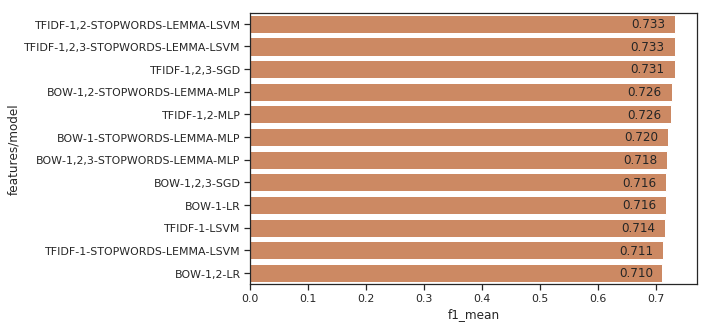

In [68]:
def adjustExp(string):
    string = string.upper()
    string = string.replace('UNIGRAM','1')
    string = string.replace('_BIGRAM',',2')
    string = string.replace('_TRIGRAM',',3')
    string = string.replace('PRE_PROCESSED','STOPWORDS-LEMMA')
    return string

metric = 'f1_mean'
df_best['features/model'] = df_best['experiment'] +['-']*len(df_best['model']) + df_best['model']
df_best['features/model'] = [adjustExp(t) for t in df_best['features/model']]
df_best = df_best.sort_values(by=metric,ascending=False)

keys = df_best['features/model']
values = df_best[metric]
sns.set(style="ticks")

plt.figure(figsize=(8, 5))
g = sns.barplot(x = values,y = keys,color='C1')

for p in g.patches:
    g.annotate(format(p.get_width(), '.3f'), (p.get_width()*0.90, 
                                               p.get_y() + p.get_height()/2.), ha = 'center', 
               va = 'center', xytext = (15, 0), textcoords = 'offset points')
    
# for p in g.patches:
#     g.annotate(format(p.get_width(), '.3f'), (p.get_y() + p.get_height() / 2., 
#                                                p.get_width()), ha = 'center', 
#                va = 'center', xytext = (0, 5), textcoords = 'offset points')

In [45]:
df_best[['features/model','vocab','fpr_mean','pre_mean','rec_mean','f1_mean']][0:10] #.to_string(index=False))

,features/model,vocab,fpr_mean,pre_mean,rec_mean,f1_mean
0,tfidf-unigram_bigram-pre_processed-lsvm,129745,0.197,0.717,0.750,0.733
1,tfidf-unigram_bigram_trigram-pre_processed-lsvm,261665,0.211,0.692,0.778,0.733
2,tfidf-unigram_bigram_trigram-sgd,384783,0.212,0.692,0.777,0.731
3,bow-unigram_bigram-pre_processed-mlp,129745,0.173,0.781,0.679,0.726
4,tfidf-unigram_bigram-mlp,156182,0.197,0.722,0.731,0.726
5,bow-unigram-pre_processed-mlp,19455,0.182,0.760,0.685,0.720
6,bow-unigram_bigram_trigram-pre_processed-mlp,261665,0.172,0.795,0.657,0.718
7,bow-unigram_bigram_trigram-sgd,384783,0.198,0.725,0.710,0.716
8,bow-unigram-lr,23422,0.184,0.761,0.677,0.716
9,tfidf-unigram-lsvm,23422,0.197,0.726,0.704,0.714


In [52]:
dif = values.max()-values.min()
dif=dif*100/values.min()
print('%.3f'%dif)
values

3.224


0     0.733
1     0.733
2     0.731
3     0.726
4     0.726
5     0.720
6     0.718
7     0.716
8     0.716
9     0.714
10    0.711
11    0.710
Name: f1_mean, dtype: float64

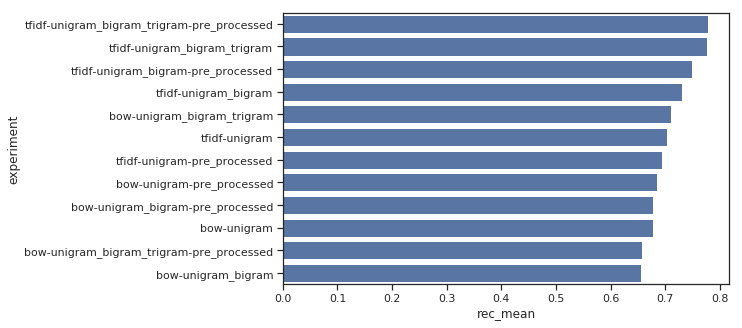

In [70]:
metric = 'rec_mean'
df_best = df_best.sort_values(by=metric,ascending=False)
x = df_best['experiment']
y = df_best[metric]
plt.figure(figsize=(8, 5))
sns.barplot(y,x,color='C0')

In [71]:
df_best['model'].value_counts()

mlp     4
lsvm    4
lr      2
sgd     2
Name: model, dtype: int64

In [72]:
print('total experiments:',len(df_best)*len(df_metrics))

total experiments: 108


# Error examples with best classifier

              precision    recall  f1-score   support

           0       0.91      0.68      0.78       135
           1       0.80      0.95      0.87       176

    accuracy                           0.83       311
   macro avg       0.85      0.82      0.82       311
weighted avg       0.85      0.83      0.83       311

Total test data: 311
Negative in test data: 135
Positive in test data: 176
False negative:  9
False positive:  43


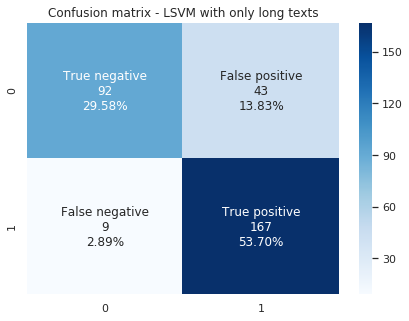

In [238]:
# 1-1 = 0 true positive
# 0-0 = 0 true negative
# 1-0 = 1 false negative
# 0-1 = -1 false positive
#clf = MLPClassifier(verbose=True, early_stopping= True, batch_size=64, n_iter_no_change = 5, tol = 1e-3).fit(X_train, y_train)
clf = LinearSVC(dual=False).fit(X_train, y_train)
y_pred = clf.predict(X_test)
#y_prob = clf.predict_proba(X_test)[:,1]
#getTestMetrics(y_test, y_pred, full_metrics = False, print_charts=True)

print(metrics.classification_report(y_test, y_pred))
cf_matrix = metrics.confusion_matrix(y_test, y_pred)
group_names = ['True negative','False positive','False negative','True positive']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(7, 5))
#plt.subplot(121)
plt.title('Confusion matrix - LSVM with only long texts')
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')


y_fails = y_test - y_pred
N = [index for index, value in enumerate(y_test) if value == 0]
P = [index for index, value in enumerate(y_test) if value == 1]
FN = [index for index, value in enumerate(y_fails) if value == 1]
FP = [index for index, value in enumerate(y_fails) if value == -1]

# 1 + 1 = 2 TP
# 0 + 0 = 0 TN
y_sucess = y_test + y_pred
TN = [index for index, value in enumerate(y_sucess) if value == 0]
TP = [index for index, value in enumerate(y_sucess) if value == 2]

print('Total test data:', len(y_pred))
print('Negative in test data:',len(N))
print('Positive in test data:',len(P))
print('False negative: ',len(FN))
print('False positive: ',len(FP))

In [79]:
full_texts_test = list(full_texts_test)

In [80]:
texts_N = [full_texts_test[n] for n in N]
texts_P = [full_texts_test[p] for p in P]
texts_FN = [full_texts_test[fn] for fn in FN]
texts_FP = [full_texts_test[fp] for fp in FP]
texts_TN = [full_texts_test[fn] for fn in TN]
texts_TP = [full_texts_test[fp] for fp in TP]

### False negative

In [81]:
for fn in texts_FN:
    print('***')
    print(fn)
    print('***')

***
No dia 07 de Outubro, quando for votar, não esqueça do que os esquerdopatas pensam da classe média.
***
***
Gente Apenas Minha Opinião então Vamos lá

No Dia 06 de Junho TSE Derruba o Voto Impresso de Autoria do deputado Federal Candidato a presidente Jair Bolsonaro

No Dia 06 de Setembro Jair Bolsonaro Sofre um Atentado que Seria pra MATAR

Um Dia Antes da Eleição Dia 06; Coincidência Se Juntar as Datas dar Certos 666 
Agora Bolsonaro corre novo Risco...

A que Interessa Isso ? Nova Ordem Mundial / Marconaria ? / iluminati ? / 
Peço que Compartilhem 
E Faca Chegar ao Bolsonaro

Breno Washington MG
Juntos somos fortes
***
***
Escuta a fala sensata e inteligente do Miguel Falabella.
👇🏻👇🏻👇🏻👇🏻👇🏻👇🏻👇🏻👇🏻👇🏻👇🏻👇🏻
***
***
A morte da velha política no Brasil, comentário de Alexandre Garcia.👇🏻👇🏻👇🏻
***
***
Conselheiros,

No Ceará descobriram que estupro é uma doença e que pode ser curada através de acupuntura...
***
***
POR ALINE PEREIRA: Republico aqui um post do mês passado, onde conto uma ex

### False positives

In [82]:
for fp in texts_FP:
    print()
    print('***')
    print(fp)
    print('***')
    print()


***
TEXTO DA FUNDADORA DO DIRETÓRIO DO PT EM ARACAJU

Esquerda brasileira, chega de apontar culpados! Está na hora de assumir o ocorrido e partir prum mea culpa já!, antes que os Dórias e Bolssonaros assumam o poder! Quem elegeu Temer não foram os coxinhas. Parem de tergiversar. Temer foi eleito por vocês com dinheiro público desviado de hospitais, creches e escolas! O resto é retórica, ou ilação como vocês agora costumam chamar o que nós brasileiros conhecemos como mentira!

A arrogância da esquerda de acreditar que lida com tolos e que porta o Santo Graal está no pano de fundo de sua derrocada mundo afora.

Vamos fazer diferente e lavar a jato essa roupa suja antes que seja tarde! A máscara caiu!

Um homem que responsabiliza a companheira morta para não assumir seus atos é um covarde e não herói . Essa inversão de valores para mim é assustadora...

E não me venham falar da corrupção que existe desde a época de CABRAL que não somos trouxinhas...Nós militamos no PT e construímos esse 

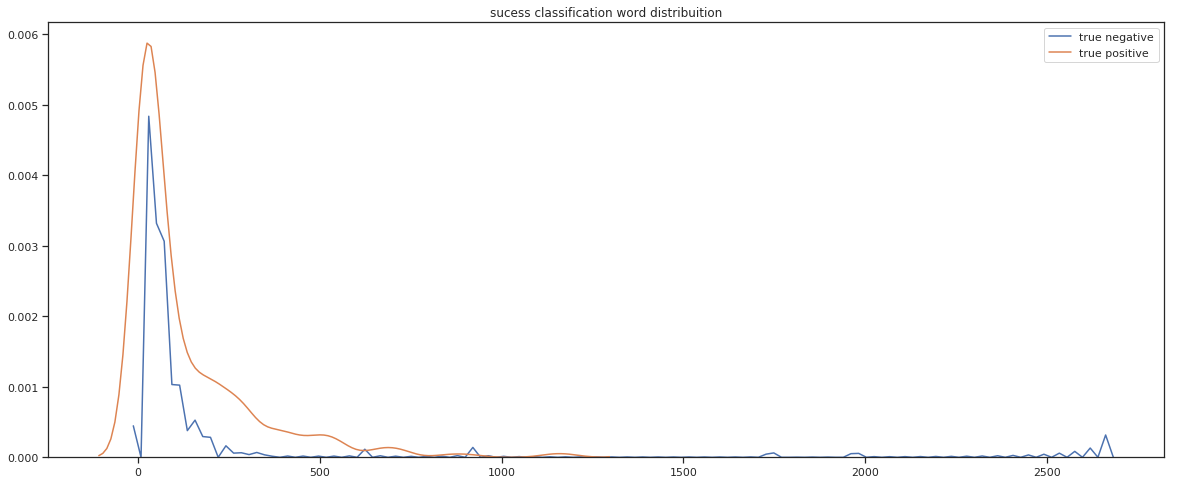

In [83]:
fn_tokens = np.array([len(t.split()) for t in texts_FN])
fp_tokens = np.array([len(t.split()) for t in texts_FP])
tn_tokens = np.array([len(t.split()) for t in texts_TN])
tp_tokens = np.array([len(t.split()) for t in texts_TP])
p_tokens = np.array([len(t.split()) for t in texts_P])
n_tokens = np.array([len(t.split()) for t in texts_N])

plt.figure(figsize=(20, 8))
plt.title('sucess classification word distribuition')
sns.distplot(tn_tokens, hist = False, kde = True, label = 'true negative')
sns.distplot(tp_tokens, hist = False, kde = True, label = 'true positive')
plt.show()


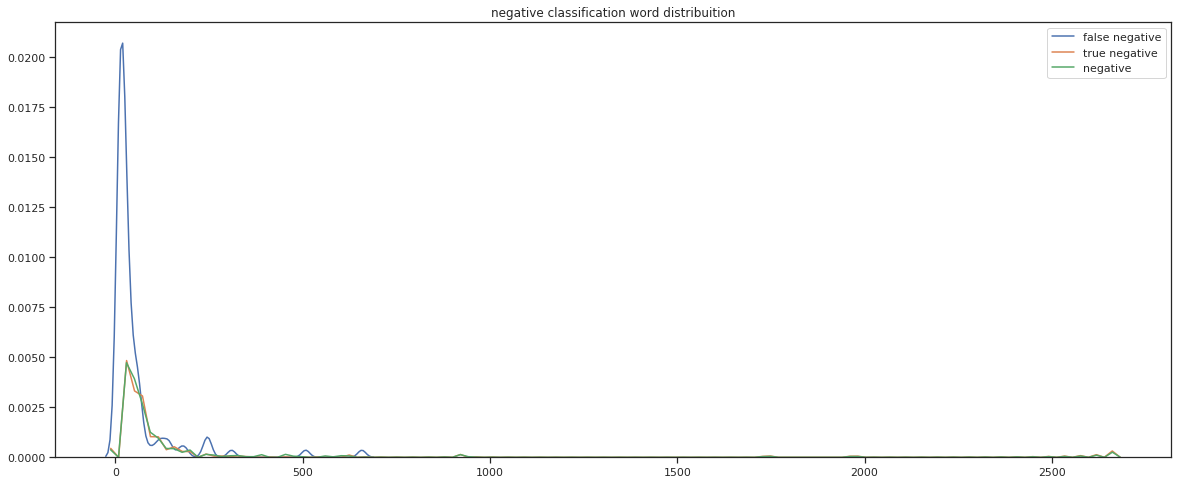

In [84]:
plt.figure(figsize=(20, 8))
plt.title('negative classification word distribuition')
sns.distplot(fn_tokens, hist = False, kde = True, label = 'false negative')
sns.distplot(tn_tokens, hist = False, kde = True, label = 'true negative')
sns.distplot(n_tokens, hist = False, kde = True, label = 'negative')
plt.show()

Negative class classification was very biased by size

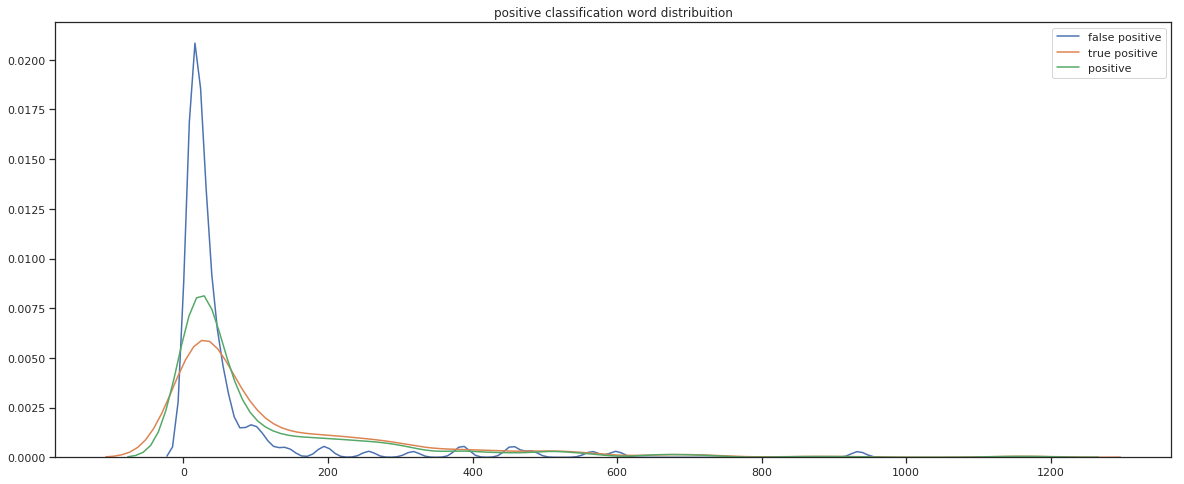

In [85]:
plt.figure(figsize=(20, 8))
plt.title('positive classification word distribuition')
sns.distplot(fp_tokens, hist = False, kde = True, label = 'false positive')
sns.distplot(tp_tokens, hist = False, kde = True, label = 'true positive')
sns.distplot(p_tokens, hist = False, kde = True, label = 'positive')
plt.show()

In [86]:
print()
print('false positive average tokens:',fp_tokens.mean())
print('true positive average tokens:',tp_tokens.mean())
print('positive average tokens:',p_tokens.mean())
print()
print('false negative average tokens:',fn_tokens.mean())
print('true negative average tokens:',tn_tokens.mean())
print('negative average tokens:',n_tokens.mean())


false positive average tokens: 65.43262411347517
true positive average tokens: 130.874251497006
positive average tokens: 112.2870159453303

false negative average tokens: 53.161904761904765
true negative average tokens: 49.42557651991614
negative average tokens: 53.077669902912625


In [87]:
fn = ['false negative']*len(texts_FN)
fp = ['false positive']*len(texts_FP)

errors_text = texts_FN + texts_FP
errors_label = fn+fp
df_errors = pd.DataFrame({'text':errors_text,'error':errors_label})
len(df_errors)
#df_errors.to_csv('results/'+base+'/'+subset+'/errors/errors-mlp.csv')

246

In [88]:
len(df_errors)

246

In [120]:
df_errors = pd.read_csv('results/2018/k-fold/errors/errors-lsvm-labels.csv')
df_errors.head()

,text,error,type
0,"No dia 07 de Outubro, quando for votar, não es...",false negative,short text with media
1,Gente Apenas Minha Opinião então Vamos lá\n\nN...,false negative,rumour
2,Escuta a fala sensata e inteligente do Miguel ...,false negative,short text with media
3,"A morte da velha política no Brasil, comentári...",false negative,short text with media
4,"Conselheiros,\n\nNo Ceará descobriram que estu...",false negative,short text with media


In [125]:
total_fn = df_errors[df_errors['error']=='false negative']['type'].value_counts().sum()
df_errors[df_errors['error']=='false negative']['type'].value_counts()/total_fn

short text with media    0.712
rumour                   0.202
false short claim        0.087
Name: type, dtype: float64

104

In [126]:
df_errors['type'] = [t if t != 'humour' else 'opinion' for t in df_errors['type']]
df_errors['type'] = [t if t != 'prayer' else 'opinion' for t in df_errors['type']]
df_errors['type'] = [t if t != 'alarmist' else 'short claim' for t in df_errors['type']]
total_fp = df_errors[df_errors['error']=='false positive']['type'].value_counts().sum()
df_errors[df_errors['error']=='false positive']['type'].value_counts()/total_fp #/len(df_errors)

short text with media    0.596
opinion                  0.234
short claim              0.170
Name: type, dtype: float64

In [123]:
a = df_errors[(df_errors['error']=='false positive') & (df_errors['type']=='short claim')]['text']
list(a)

['*RECEBI AGORA UM ALERTA:*\n\nAtenção!! Está circulando aí um pedido para que adicione Flávio Bolsonaro nos seus  contatos . Não faça isso pois é fake;  é um hacker que está tentando pegar dados de celular.  Passe para quem você puder. Isso foi checado.\nÉ FAKE !!',
 'Quando o PT dissemina fake news, o G1 chama de "acusação equivocada". Pára que tá feio Globo! Imprensa desmoralizada!!!',
 'LIMPEZA ATUALIZADA: \nSuplicy ✖\nLindenbergh ✖\nDilma ✖\nPimentel ✖\nRosseto ✖\nRequiao ✖\nCristovam Buarque ✖\nBeto Richa ✖\nJean Wyllis ✖\nVanessa Graziottin ✖\nEdison lobao ✖\nVicentinho ✖\nSarney filho ✖\nJorge Viana ✖\nRoseana Sarney ✖\n\nAnd counting!',
 'A vida inteira a Globo e outros meios da grande mídia espalham notícias falsa.\nMas o problema, segundo o PT, é o WhatsApp.',
 'Sobre Adélio eu só tenho uma curiosidade:\n\ncomo é que um servente de pedreiro DESEMPREGADO já tinha uma equipe de advogados engatilhada?\n\nE olha, não são porta-de-cadeia não...\n\nSe alguém puder me explicar...\n